<a href="https://colab.research.google.com/github/JoshGrose/Surrogate-Model/blob/main/surrogate_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Imports and Paths
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import math

import joblib

# implement Neural Network to learn the full dataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
#from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.models import load_model

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf
from tensorflow.python.keras import optimizer_v2 as opt

import warnings
warnings.filterwarnings("ignore")

# connect to drive

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  filepath = '/content/gdrive/My Drive/Colab Notebooks/'
except:
  print("Not Connected to Google Colab")
  filepath = '/home1/07329/joshg/surrogate_model'


#filepath = '/content/gdrive/My Drive/Colab Notebooks/'

print(filepath)
print('This was sent back from the TACC Jupyter Notebook')

Not Connected to Google Colab
/home1/07329/joshg/surrogate_model
This was sent back from the TACC Jupyter Notebook


In [2]:
#@title Check for GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
#@title Check for Higher RAM

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
#@title System and Model Parameters
# mask information
#train_img = 'ibeam'
#test_img = 'circle'  #'yinyang' #'circle'  #'square_1mm' # 'leaf'
train_img_list = ['ibeam_bd3_8','ibeam_bd3_6','ibeam_bd3_4','ibeam_bd3_2',
                  'smallsquare_bd3_8','smallsquare_bd3_6','smallsquare_bd3_4','smallsquare_bd3_2',
                  'yinyang_bd3_8','yinyang_bd3_6','yinyang_bd3_4','yinyang_bd3_2'] #, 'square_1mm','rectangle'] #, 'square_1mm'] #['ibeam','yinyang','smallsquare'] #,'square_1mm','spiral']

mask_list = ['square_opt_rev_1','square_opt_rev_2','square_opt_rev_3','square_opt_rev_4',
                    'square_opt_rev_5','square_opt_rev_6','square_opt_rev_7','square_opt_rev_8',
                    'square_opt_rev_9','square_opt_rev_10','square_opt_rev_11','square_opt_rev_12',]

'''
['square_opt_1','square_opt_2','square_opt_3','square_opt_4',
                    'square_opt_5','square_opt_6','square_opt_7','square_opt_8',
                    'square_opt_9','square_opt_10','square_opt_11','square_opt_12',]
'''


pred_img_list = ['square_opt_rev']  # square_opt2 is the current full mask optimized result (without property updates)

timestep_dict = {
    'assassin': 134,
    'leaf': 133,
    'dragon': 133,
    'square_1mm_val': 133,
    'circle': 133,
    'longhorn': 134,
    'spiral': 133,
    'assassin_val': 118,
    'leaf_val': 117,
    'dragon_val': 125,
    'square_1mm_val': 133,
    'circle_val': 133,
    'longhorn_val': 117,
    'spiral_val': 119,
    'circle_bd3_2':195,
    'circle_bd3_6':222
}

# Major Script Parameters
num_timesteps =  131 #timestep_dict[pred_img_list[0]] #assassin_val: 118,  leaf_val: 117,  dragon_val: 125, square_1mm_val/circle_val: 133    #118, plus  # set based on the mask data
task = 'pred' # 'train', 'pred'
dist_exp = 1.21 #1.21 # 1.2 for BIS a,b 
model_name = 'qgen_distance_added_BIS_1_21_gray2s_16_nodes' #_nozones1_5

#checkpoint = ModelCheckpoint(.....) # use this to periodically save weights when training long model in background
model_type = 'nn' # 'nn', 'xgb', 'lgbm', 'rf'
act_fun = 'relu' # 'relu' for BIS 

# Neural Network Parameters
num_nodes = 20 # 16 for BIS
num_hidden_layers = 3

# Xgboost parameters 
xgb_params = {'n_estimators': 600,
        'verbose': 0,    
        'max_depth': 12,
        'learning_rate': 0.02,
        'tree_method': "hist"}

# LightGBM
lgbm_params = {'objective': 'regression',
              'metric': 'l2',
              'is_unballanced': 'true',
              'boosting': 'gbdt',
              'num_leaves': 280,
              'feature_fraction': 0.6,
              'baging_fraction': 0.9,
              'bagging_freq': 10,
              'learning_rate': 0.03,
              'verbose': -1,
              'num_trees': 400
              }

# FEATURE TUNING
features = ['temp','qgen']
num_feat = len(features)
num_adjacent = 1  # number of adjacent element features added to feature list
udrl = False # for BIS... False
single_temp = False # for BIS... False
single_qgen = False # for BIS... False
single_dens = False # FALSE for BIS
single_dens_change = True # NEW
single_qgen_dist = True
time_subset = True

zone_exp = True # for BIS... True
circle_zones = True #True for BIS a, False for b
incl_time = True # False for BIS
qgen_zones = True # True for BIS
delay_jump = 0 # for BIS... 0

pred_start = 100 # what timestep should the prediction begin?

zone_depth = 2 #2 for BIS  # number of adjacent elements included in each zone
num_zones = 6 + delay_jump #6 for BIS w/qgen_dist  # number of adjacent zone features added to features list
num_mask_train = len(train_img_list)
#incl_elems = 1+8*num_adjacent  # currently set for full zones... u,d,r,l would be 8* instead of 4*

col_num_train = num_zones+num_feat*(2*num_adjacent+1)**2

# timestep/loadstep information
num_ls = 15
ls_time = .2
start_ts = 16  # THIS SHOULD NOT BE HARD CODED.... .2s/beginning of real simulation
sinter_time = .2
train_ts = 133 # 133 here works with "num_timesteps = 131"

# initial temperature to initialize training data
temp_init = 22
dens_init = 2600

# mesh parameters
mesh_x = 60
mesh_y = 118

# aditional parameters
num_time = 240 #180 for non val   # (It's used somewhere...)
x_min = .00125
x_max = .00275
y_min = .00150
y_max = .00450
z_min = 0

In [ ]:
#@title import_data
def import_data(filepath, name, sep='       |      |     |    |   |  | '):
      """Returns imported data"""
      return(pd.read_csv(filepath + name, sep, header=None).to_numpy(copy=True))

In [ ]:
#@title getLastVal
def getLastVal(val_mat):
    '''Get last nonzero value for filtering'''
    binary_array = (val_mat[0,0,:]!=0.0) #.argmax()
    last_val = np.argmax(binary_array == False)
    return last_val

In [ ]:
#@title filterStart
def filterStart(val_mat,start_ts,time=False):
    '''filter out initial bad data'''
    if time == False:
        val_mat_filt = val_mat[:,:,start_ts:]
    else:
        val_mat_filt = val_mat[start_ts:]
    
    return val_mat_filt

In [ ]:
#@title filterEnd
def filterEnd(val_mat, last_val, time=False):
    '''filter out initial bad data'''
    if time == False:
        val_mat_filt = val_mat[:,:,:last_val]
    else:
        val_mat_filt = val_mat[:last_val]
    
    return val_mat_filt

In [ ]:
#@title setTimeZero
def setTimeZero(val_array, initial_val=22, param='temp'):
    '''Insert initial condition to matrices'''

    if param == 'temp':
        val_array_init =  np.insert(val_array,0,initial_val,2)
    elif param == 'change':
        val_array_init =  np.insert(val_array,0,0,2)
    else:
        val_array_init =  np.insert(val_array,0,val_array[:,:,0],2)

    return val_array_init

In [ ]:
#@title setTempMin
def setTempMin(temp_array):
    temp_array[temp_array<22] = 22
    return temp_array

In [ ]:
#@title createTemperatureMatrix
# function library for bed-scale data processing
def createTemperatureMatrix(filepath, img_string, num_ls = 9, ls_time = .2, start_ts = 16, mesh_x = 60,
                mesh_y = 118, num_time = 180, x_min = .00125, x_max = .00275,
                y_min = .00150, y_max = .00450, z_min = 0):

    # Timeseries Data
    timeseries_name = 'timeseries_' + img_string + '.txt'

    # node and element data
    nodenums_name = 'node_numbers.txt'
    node_list_name = 'node_list.txt'
    elem_coords_name = 'element_coordinates.txt'

    # element location data for qgen and dens
    centx_name = 'centX_filt.txt'
    centy_name = 'centY_filt.txt'

    # import key variables from text files
    nodenums_array_unfilt = import_data(filepath, nodenums_name)
    nodenums_array = nodenums_array_unfilt[:,:-1]

    elem_loc_array  = import_data(filepath, elem_coords_name)
    full_timeseries  = import_data(filepath, timeseries_name)

    # split full timeseries into times and temps
    temp_timeseries = full_timeseries[:,1:]
    time_array_unfilt = full_timeseries[:,0]
    time_array = time_array_unfilt[time_array_unfilt != 0]

    #print(temp_timeseries.shape)
    # boundary conditions to filter elements outside of the main section
    a = elem_loc_array[0, :] > x_min
    b = elem_loc_array[0, :] < x_max
    c = elem_loc_array[1, :] > y_min
    d = elem_loc_array[1, :] < y_max
    e = elem_loc_array[2, :] > z_min

    # filter for elements within "main" copper
    elem_nodes = []
    elem_coords = []

    for i in range(0, nodenums_array.shape[1]):
        if a[i] and b[i] and c[i] and d[i] and e[i]:
            #elem_nodes.append(list(nodenums_array[:, i]))
            elem_coords.append(list(elem_loc_array[:, i]))
            elem_nodes.append(list(nodenums_array[:, i]))

    #PLEASE RENAME THESE
    elem_nodes = np.array(elem_nodes)
    elem_coords = np.array(elem_coords)
    xy = elem_coords[:, :2]

    # combine array of element nodes with array of x,y element data
    elem_array = np.vstack((xy.transpose(), elem_nodes.transpose())).transpose()

    # convert to list for sorting
    elem_list = list(elem_array)
    elem_sorted = np.array(sorted(elem_list, key=lambda k: [k[1], -k[0]])).transpose()
    #print(elem_sorted)

    # split elem sorted into two seperate numpy arrays
    num_dim = 2  # only x,y coordinates need to be sorted
    xy_sorted = elem_sorted[:num_dim, :]
    elem_nodes_sorted = elem_sorted[num_dim:, :]

    x_ordered = np.reshape(xy_sorted[0], (mesh_x, mesh_y), order='C')
    y_ordered = np.reshape(xy_sorted[1], (mesh_x, mesh_y), order='C')

    # loop to build ordered element nodes list
    num_nodes = len(elem_nodes_sorted[:,0])
    elem_nodes_mat = np.zeros((mesh_x, mesh_y, num_nodes))  # 20 for 20 nodes
    temp_mat = np.zeros((mesh_x, mesh_y,num_time))
    counter = 0

    temp_list = []

    for col in range(0, mesh_y):
        for row in range(0, mesh_x):
            node_set = elem_nodes_sorted[:, counter]
            #print(node_set)

            elem_nodes_mat[row, col, :] = node_set
            temp_array = np.zeros((num_time, num_nodes))

            # timeseries data orginization
            for node_num in range(0, num_nodes):
                # get absolute node
                node = node_set[node_num]
                div = len(np.nonzero(node_set)[0])
                if node != 0.0:
                    temp_array[:, [node_num]] = temp_timeseries[:, [int(node)-1]]

            # for every timestep, sum temp values for all nodes in element
            temp_array_avg = np.sum(temp_array, axis=1)/div  #/num_nodes
            temp_list.append(temp_array)

            temp_mat[row, col, :] = temp_array_avg

            counter=counter+1

    # TIMESERIES DONE

    return temp_mat, time_array, start_ts

In [ ]:
#@title createFeatureMatrix
def createFeatureMatrix(filepath, filename, time_array, num_ls = 9, ls_time = .2, start_ts = 16, mesh_x = 60,
                mesh_y = 118, num_time = 180, x_min = .00125, x_max = .00275,
                y_min = .00150, y_max = .00450, z_min = 0):

    # element location data for qgen and dens
    centx_name = 'centX_filt.txt'
    centy_name = 'centY_filt.txt'


    # Density/Qgen or any other imported feature
    feature_array  = import_data(filepath, filename, sep=',')
    centx_array  = import_data(filepath, centx_name, sep='/n').transpose()
    centy_array  = import_data(filepath, centy_name, sep='/n').transpose()

    elem_array = np.vstack((centx_array, centy_array, feature_array)).transpose()

    # convert to list for sorting
    elem_list = list(elem_array)
    elem_sorted = np.array(sorted(elem_list, key=lambda k: [k[1], -k[0]])).transpose()

    # split elem sorted into two seperate numpy arrays
    num_dim = 2  # only x,y coordinates need to be sorted
    xy_sorted = elem_sorted[:num_dim, :]
    feature_sorted = elem_sorted[num_dim: num_dim + num_ls, :]

    # structure the feature matrices
    feature_mat = np.zeros((mesh_x, mesh_y, num_time))
    #print(feature_mat.shape)

    counter = 0
    #print(num_ls)
    for col in range(0, mesh_y):
        for row in range(0, mesh_x):

            time_ind_old = 0
            # added code to extend density and qgen over timeseries instead of just loadstep
            # this code ignores the first few timesteps where nothing happens
            for ls in range(1,num_ls+1):

                time_end = round(ls*ls_time,4)
                time_ind = np.where(time_array == time_end)
                #print(time_end)
                #print(time_end + 1.0)
                time_ind = time_ind[0][0]  # doesnt work for ts = 240 and ls = 9

                feature_mat[row, col, time_ind_old:time_ind] = feature_sorted[ls-1, counter]
                time_ind_old = time_ind

            counter=counter+1


    return feature_mat

In [ ]:
#@title createMaskSegment
def createMaskSegment(filepath, filename, time_array, num_ls = 9, ls_time = .2, start_ts = 16, mesh_x = 60,
                mesh_y = 118, start_ls = 0, ls_duration = 1, x_min = .00125, x_max = .00275,
                y_min = .00150, y_max = .00450, z_min = 0):

    # ls_duration -> number of loadsteps that this mask should remain on filepath, qgen_name, time_array, start_ls = start_ls, ls_duration = ls_duration, num_ls = num_ls

    # element location data for qgen and dens
    centx_name = 'centX_filt.txt'
    centy_name = 'centY_filt.txt'


    # Density/Qgen or any other imported feature
    feature_array  = import_data(filepath, filename, sep=',')
    centx_array  = import_data(filepath, centx_name, sep='/n').transpose()
    centy_array  = import_data(filepath, centy_name, sep='/n').transpose()

    elem_array = np.vstack((centx_array, centy_array, feature_array)).transpose()

    # convert to list for sorting
    elem_list = list(elem_array)
    elem_sorted = np.array(sorted(elem_list, key=lambda k: [k[1], -k[0]])).transpose()

    # split elem sorted into two seperate numpy arrays
    num_dim = 2  # only x,y coordinates need to be sorted
    xy_sorted = elem_sorted[:num_dim, :]
    feature_sorted = elem_sorted[num_dim: num_dim + num_ls, :]

    # initial and final time indices
    
    if start_ls == 0:
        time_start = 0.2000
        time_start_ind = 0
    else:
        time_start = round((start_ls+1)*ls_time,4)
        #print(start_ls)
        #print(time_start)
        time_start_loc = np.where(time_array == time_start)
        time_start_ind = time_start_loc[0][0]

    time_end = round(time_start + ls_duration*ls_time,4)
    time_end_loc = np.where(time_array == time_end)
    time_end_ind = time_end_loc[0][0]  # doesnt work for ts = 240 and ls = 9
    
    # structure the feature matrices
    #print('min time')
    #print(np.amin(time_array[:]))
  
    #print(time_end_ind - time_start_ind)
    feature_mat = np.zeros((mesh_x, mesh_y, time_end_ind - time_start_ind))

    counter = 0
    #print(num_ls)
    for col in range(0, mesh_y):
        for row in range(0, mesh_x):
                        
            feature_mat[row, col, :] = feature_sorted[0, counter] # any index should work for this, since the qgen file is uniform
            counter=counter+1

    return feature_mat

In [ ]:
#@title getAdjacentFeatures
def getAdjacentFeatures(temp_mat, last_val, mesh_x=60, mesh_y=118, num_adjacent = 1, udrl = False):

    # get size parameters needed to formulate training data
    adj = num_adjacent
    num_time_filt = last_val
    num_elem = mesh_x*mesh_y
    num_points = num_time_filt*num_elem - num_elem

    # get expanded matrix for easier looping
    temp_mat_exp = expandTempMeshTrain(temp_mat, num_adjacent)
    shape = temp_mat_exp.shape

    # get the number of features
    u_bound, l_bound = 0, 0    # this being 0 might account for the center element data (no need for the +1)
    for adj in range(1, num_adjacent+1):
        u_bound += adj*8
    num_cols = u_bound + 1

    # set the size of the feature matrix
    features_mat = np.zeros((num_points, num_cols))  # can also be num_adjacent*8 for the number of surrounding points

    counter = 0
    # no need to loop through, just reshape the matrix and make sure the intended column vectors are correct
    for col in range(num_adjacent, mesh_y+adj):
        for row in range(num_adjacent, mesh_x+adj): # NEED TO ACCOUNT FOR ADJ=0

            feature_columns = temp_mat_exp[row-adj:row+adj+1,col-adj:col+adj+1,:-1].reshape(num_cols,shape[2]-1).T #.reshape(shape[2]-1,num_cols)    #order='C', exclude final column
            features_mat[counter:num_points:num_elem, l_bound:num_cols] = feature_columns
            counter+=1

    # only get features corresponding to up, down, right, left elements
    if udrl and num_adjacent == 1:
        features_mat = features_mat[:, 1::2]

    return features_mat, temp_mat_exp

In [ ]:
#@title getAdjacentFeaturesPredict
def getAdjacentFeaturesPredict(temp_mat, last_val, mesh_x=60, mesh_y=118, num_adjacent = 1, udrl = False):

    # get size parameters needed to formulate training data
    adj = num_adjacent
    num_time_filt = last_val
    num_elem = mesh_x*mesh_y

    # get expanded matrix for easier looping
    temp_mat_exp = expandTempMeshPredict(temp_mat, num_adjacent)
    shape = temp_mat_exp.shape

    # get the number of features
    u_bound, l_bound = 0, 0    # this being 0 might account for the center element data (no need for the +1)
    for adj in range(1, num_adjacent+1):
        u_bound += adj*8
    num_cols = u_bound + 1

    # set the size of the feature matrix
    features_mat = np.zeros((num_elem, num_cols))  # can also be num_adjacent*8 for the number of surrounding points

    counter = 0
    # no need to loop through, just reshape the matrix and make sure the intended column vectors are correct
    for col in range(num_adjacent, mesh_y+adj):
        for row in range(num_adjacent, mesh_x+adj):

            #print(temp_mat_exp[row-adj:row+adj+1,col-adj:col+adj+1])
            feature_columns = temp_mat_exp[row-adj:row+adj+1,col-adj:col+adj+1].reshape(1,num_cols)    #order='C', exclude final column
            features_mat[counter, l_bound:num_cols] = feature_columns

            counter+=1

    if udrl and num_adjacent == 1:
        features_mat = features_mat[:, 1::2]

    return features_mat, temp_mat_exp

In [ ]:
#@title getAdjacentSingle
def getAdjacentSingle(temp_mat_train, last_val, mesh_x=60, mesh_y=118):

    #num_feats = num_feat*incl_elems  # +1 for density change
    num_time_filt = last_val
    num_elem = mesh_x*mesh_y

    num_points = num_time_filt*num_elem - num_elem

    label_data = np.zeros((num_points, 1)) # SINGLE LABEL
    counter = 0
    for col in range(0, mesh_y):
        for row in range(0, mesh_x):
            label_data[counter:num_points:num_elem, 0] = temp_mat_train[row,col,:-1]
            counter+=1

    return label_data

In [ ]:
#@title getAdjacentSinglePredict
def getAdjacentSinglePredict(feat_mat, last_val, mesh_x=60, mesh_y=118):

    num_elem = mesh_x*mesh_y
    label_data = np.zeros((num_elem, 1)) # SINGLE LABEL

    counter = 0
    for col in range(0, mesh_y):
        for row in range(0, mesh_x):
            label_data[counter, 0] = feat_mat[row,col]
            counter+=1

    return label_data

In [ ]:
#@title get_time_feat_predict
def get_time_feat_predict(time_delta, mesh_x, mesh_y):
    
    num_elem = mesh_x*mesh_y
    time_data = np.zeros((num_elem, 1)) + time_delta # SINGLE LABEL

    return time_data

In [ ]:
#@title get_time_feat
def get_time_feat(time_diff_array, mesh_x, mesh_y, last_val):
    
    #num_feats = num_feat*incl_elems  # +1 for density change
    num_time_filt = last_val
    num_elem = mesh_x*mesh_y

    num_points = num_time_filt*num_elem - num_elem

    time_data = np.zeros((num_points, 1)) # SINGLE LABEL
    counter = 0
    for col in range(0, mesh_y):
        for row in range(0, mesh_x):
            time_data[counter:num_points:num_elem, 0] = time_diff_array
            counter+=1

    return time_data

In [ ]:
#@title expandTempMeshPredict
def expandTempMeshPredict(temp_mat, num_included_elems):
    '''
    This works for multiple timesteps all at once
    '''
    # temp_map is a timestep slice of the full temp_mat (ex: all temperatures at a specified timestep)

    n = num_included_elems
    # expand left, down, up, right (CCW)

    # add left columns
    temp_shape = temp_mat.shape
    #print(temp_shape)

    left_temps = np.reshape(temp_mat[:,0],(-1,1)) #np.reshape(temp_mat[:,0,:], (temp_shape[0],-1,temp_shape[2])) #y=np.reshape(y, (-1,1))
    left_temps_opp = np.tile(left_temps, (1,n)) #temp_mat[:,1:n+1]
    left_array = left_temps_opp #np.flip(left_temps - abs(left_temps - left_temps_opp), axis=1)
    temp_mat = np.hstack((left_array,temp_mat))
    temp_shape = temp_mat.shape

    # add bottom rows
    #print(temp_mat[-1,:,:].shape)
    bottom_temps = np.reshape(temp_mat[-1,:],(1,-1)) #np.reshape(temp_mat[-1,:,:], (-1,temp_shape[1],temp_shape[2]))
    bottom_temps_opp = np.tile(bottom_temps, (n,1)) #temp_mat[-1*n-1:-1,:]
    bottom_array = bottom_temps_opp #np.flip(bottom_temps - abs(bottom_temps - bottom_temps_opp), axis=0)
    temp_mat = np.vstack((temp_mat, bottom_array))
    temp_shape = temp_mat.shape

    # add right columns
    right_temps = np.reshape(temp_mat[:,-1],(-1,1)) #np.reshape(temp_mat[:,-1,:], (temp_shape[0],-1,temp_shape[2]))
    right_temps_opp = np.tile(right_temps, (1,n)) #temp_mat[:,-1*n-1:-1]
    #print(right_temps.shape)
    right_array = right_temps_opp  #np.flip(right_temps - abs(right_temps - right_temps_opp), axis=1)
    temp_mat = np.hstack((temp_mat, right_array))
    temp_shape = temp_mat.shape

    # add top rows
    top_temps = np.reshape(temp_mat[0,:],(1,-1)) #np.reshape(temp_mat[0,:,:], (-1,temp_shape[1],temp_shape[2]))
    top_temps_opp = np.tile(top_temps, (n,1)) #temp_mat[1:n+1,:]
    #print(top_temps.shape)
    top_array = top_temps_opp #np.flip(top_temps - abs(top_temps - top_temps_opp), axis=0)
    temp_mat = np.vstack((top_array, temp_mat))

    #print(temp_mat.shape)

    return temp_mat


In [ ]:
#@title expandTempMeshTrain
def expandTempMeshTrain(temp_mat, num_included_elems):
    '''
    This works for multiple timesteps all at once
    '''
    # temp_map is a timestep slice of the full temp_mat (ex: all temperatures at a specified timestep)

    n = num_included_elems
    # expand left, down, up, right (CCW)

    # add left columns
    temp_shape = temp_mat.shape
    #print(temp_shape)

    left_temps = np.reshape(temp_mat[:,0,:], (temp_shape[0],-1,temp_shape[2]))
    #print(left_temps.shape)
    ####left_temps = temp_mat[:,0, :]
    print(left_temps.shape)
    left_array = np.tile(left_temps, (1,n,1))  #np.flip(temp_mat[:,1:n+1, :], axis = 1) #np.flip(left_temps - abs(left_temps - temp_mat[:,1:n+1, :]), axis=1)
    temp_mat = np.hstack((left_array,temp_mat))
    temp_shape = temp_mat.shape

    # add bottom rows
    #print(temp_mat[-1,:,:].shape)
    bottom_temps = np.reshape(temp_mat[-1,:,:], (-1,temp_shape[1],temp_shape[2]))
    #print(bottom_temps.shape)
    #bottom_temps = temp_mat[-1,:, :]
    bottom_array = np.tile(bottom_temps, (n,1,1)) #np.flip(bottom_temps - abs(bottom_temps - temp_mat[-1*n-1:-1,:,:]), axis=0)
    temp_mat = np.vstack((temp_mat, bottom_array))
    temp_shape = temp_mat.shape

    # add right columns
    right_temps = np.reshape(temp_mat[:,-1,:], (temp_shape[0],-1,temp_shape[2]))
    #print(right_temps.shape)
    ####right_temps = temp_mat[:,-1, :]
    right_array = np.tile(right_temps, (1,n,1)) #np.flip(right_temps - abs(right_temps - temp_mat[:,-1*n-1:-1,:]), axis=1)
    temp_mat = np.hstack((temp_mat, right_array))
    temp_shape = temp_mat.shape

    # add top rows
    top_temps = np.reshape(temp_mat[0,:,:], (-1,temp_shape[1],temp_shape[2]))
    #print(top_temps.shape)
    ####top_temps = temp_mat[:,0, :]
    top_array = np.tile(top_temps, (n,1,1)) #np.flip(top_temps - abs(top_temps - temp_mat[1:n+1,:,:]), axis=0)
    temp_mat = np.vstack((top_array, temp_mat))
    temp_shape = temp_mat.shape

    return temp_mat

In [ ]:
#@title getFeatureZones
def getFeatureZones(temp_map, qgen_mat, last_val, mesh_x=60, mesh_y=118, num_zones = 3, zone_depth = 3, num_feat = 3, num_adjacent = 1):


    num_time_filt = last_val
    num_elem = mesh_x*mesh_y
    num_points = num_time_filt*num_elem - num_elem

    temp_mat_exp = expandTempMeshTrain(temp_map, num_zones)

    features_mat = np.zeros((num_points, num_zones))  # can also be num_adjacent*8 for the number of surrounding points
    counter = 0
    for col_num in range(num_zones, mesh_y+num_zones):
        for row_num in range(num_zones, mesh_x+num_zones):

            row = row_num + num_zones
            col = 1

            features_mat[counter:num_points:num_elem, :] = temp_mat_exp[row,col,:-1]
            features_mat[counter:num_points:num_elem, :] = temp_mat_exp[row,col,:-1]
            features_mat[counter:num_points:num_elem, :] = temp_mat_exp[row,col,:-1]
            features_mat[counter:num_points:num_elem, :] = temp_mat_exp[row,col,:-1]
            training_data[counter:num_points:num_elem, col_adj] = temp_mat_train[row+col_adj,col,:-1]


    return zone_features

In [ ]:
#@title getFeaturesFromMask
# below code nees to be run for all input training masks
# make sure all TRAINING matrices are the same size...

def getFeaturesFromMask(filepath, train_img, num_time, num_ls):

    dens_name = 'density_filt_'  + train_img + '.txt'
    qgen_name = 'qgen_norm_filt_'  + train_img + '.txt'
    temp_mat, time_array, start_ts = createTemperatureMatrix(filepath, train_img, num_time = num_time)
    dens_mat = createFeatureMatrix(filepath, dens_name, time_array, num_time = num_time, num_ls = num_ls) # currently not running for ts=240, ls=9
    qgen_mat = createFeatureMatrix(filepath, qgen_name, time_array, num_time = num_time, num_ls = num_ls)
    #print(dens_mat.shape)
    temp_mat = filterStart(temp_mat, start_ts)
    last_val = getLastVal(temp_mat)
    temp_mat = filterEnd(temp_mat, last_val)
    #print(last_val)
    dens_mat = filterEnd(dens_mat, last_val)
    qgen_mat = filterEnd(qgen_mat, last_val)
    #print(dens_mat.shape)

    temp_mat = setTimeZero(temp_mat, initial_val=temp_init, param='temp')
    #print(dens_mat.shape)
    dens_mat = setTimeZero(dens_mat, param='dens')
    qgen_mat = setTimeZero(qgen_mat, param='qgen')

    # get density change as a feature
    dens_change_mat = dens_mat[:, :, 1:] - dens_mat[:, :, :-1]
    dens_change_mat = setTimeZero(dens_change_mat, param='change') # set time 0 for density CHANGE

    # adjust last val for t0 values
    last_val+=1

    # set minimum temperature to 0
    temp_mat = setTempMin(temp_mat)

    # filter and append to time array (as was done above for the other arrays)

    time_array = filterStart(time_array, start_ts-1, time = True)
    time_array = filterEnd(time_array, last_val, time = True)

    time_diff_array = time_array[1:] - time_array[:-1]
    #time_diff_array = time_array

    return temp_mat, dens_mat, dens_change_mat, qgen_mat, last_val, time_diff_array, time_array

In [ ]:
#@title getQgenFromMask
# below code nees to be run for all input training masks
# make sure all TRAINING matrices are the same size...

def getQgenFromMask(filepath, mask_img, num_time, num_ls, time_array,  start_ls = 0, ls_duration = 1):

    qgen_name = 'qgen_norm_filt_'  + mask_img + '.txt'
    qgen_mat = createMaskSegment(filepath, qgen_name, time_array, start_ls = start_ls, ls_duration = ls_duration, num_ls = num_ls)
    qgen_mat = filterEnd(qgen_mat, last_val)
    qgen_mat = setTimeZero(qgen_mat, param='qgen')

    return qgen_mat

In [ ]:
#@title getTemperatureLabels
def getTemperatureLabels(temp_mat_train, last_val, mesh_x=60, mesh_y=118,):

    #num_feats = num_feat*incl_elems  # +1 for density change
    num_time_filt = last_val
    num_elem = mesh_x*mesh_y

    num_points = num_time_filt*num_elem - num_elem

    label_data = np.zeros((num_points, 1)) # SINGLE LABEL
    counter = 0
    for col in range(0, mesh_y):
        for row in range(0, mesh_x):
            label_data[counter:num_points:num_elem, 0] = temp_mat_train[row,col,1:]
            counter+=1

    return label_data

In [ ]:
#@title getQgenZones
def getQgenZones(qgen_mat, mesh_x=60, mesh_y=118, num_zones = 3, zone_depth = 3, zone_jump = 1, zone_increase = 2, delay_jump = 0, circle_zones = False, zone_exp = False):
    '''
    Create mesh shaped data structure for each of the surrounding mesh zones
    timestep -1 of qgen_mat is being used here since all timesteps are the same
    this will eventually be replaced with whatever mask is being used

    Can certainly parallelize this...

    zone_depth: size of qgen zones... if zone_exp, size of starting qgen zone
    zone_jump: every [zone_jump] zones, the zone_depth increases by zone_increase
      
    '''

    toggle = 'off' #'mult' #'mult', 'custom', 'off'
    circzone_shift = .5 # .5 for BIS

    arm_len_list = [2, 4, 6, 8, 10, 14, 20, 24, 30, 36, 42, 48]  # only if toggle = 'custom'

    num_elem = mesh_x*mesh_y
    counter = 0
    box_half_len = num_zones*zone_depth
    full_zone_depth = zone_depth  # starting length of first zone (2, meaning the zone will be 5x5)

    zone_list = []
    #zone_increase = 1

    for zone_num in range(1, num_zones+1):
        #####print('Arm Len')
        #print(zone_depth)
        #print(full_zone_depth)

        if toggle == 'mult':
            arm_len = zone_num*zone_depth # this is the old way that generated the BIS model

        elif toggle == 'custom':
            arm_len = arm_len_list[zone_num-1]

        else:
            arm_len = full_zone_depth

        #####print(arm_len)

        # create empty matrix and populate with sums for each consecutive zone
        zone_mat = np.zeros((mesh_x, mesh_y))
        for col in range(0, mesh_y):
            for row in range(0, mesh_x):

                from_bottom = mesh_x-row-1
                from_right = mesh_y-col-1

                bottom_dist = min(from_bottom, arm_len)
                top_dist = min(row, arm_len)
                left_dist = min(col, arm_len)
                right_dist = min(from_right, arm_len)

                qgen_zone = qgen_mat[row-top_dist:row+bottom_dist+1, col-left_dist:col+right_dist+1]

                # added in the +1s to include symmetrical zones
                if circle_zones == True:

                    pad_dist_b = arm_len - bottom_dist  # all of these can be 0 if dist = arm_len
                    pad_dist_t = arm_len - top_dist
                    pad_dist_l = arm_len - left_dist
                    pad_dist_r = arm_len - right_dist

                    padded_zone = qgen_zone.copy()

                    if pad_dist_b != 0:
                        pad_mat_b = np.zeros((pad_dist_b, padded_zone.shape[1]))
                        padded_zone = np.vstack((padded_zone, pad_mat_b))

                    if pad_dist_t != 0:
                        pad_mat_t = np.zeros((pad_dist_t, padded_zone.shape[1]))
                        padded_zone = np.vstack((pad_mat_t, padded_zone))

                    if pad_dist_l != 0:
                        pad_mat_l = np.zeros((padded_zone.shape[0], pad_dist_l))
                        padded_zone = np.hstack((pad_mat_l, padded_zone)) 
                    

                    if pad_dist_r != 0:
                        pad_mat_r = np.zeros((padded_zone.shape[0], pad_dist_r))
                        padded_zone = np.hstack((padded_zone, pad_mat_r))


                    #pass                                 
                    qgen_zone = padded_zone   
                    a = np.ones((qgen_zone.shape[0],qgen_zone.shape[1]))
                    b = np.reshape(np.arange(1,qgen_zone.shape[0]+1),(-1,1))
                    #b2 = np.reshape(np.arange(1,qgen_zone.shape[1]+1),(1,-1))
                    
                    rowset = a*b
                    colset = a*b.T
                    dist = ((rowset-qgen_zone.shape[0]/2-.5)**2+(colset-qgen_zone.shape[1]/2-.5)**2)**.5
                    qgen_zone[dist>qgen_zone.shape[0]/2+circzone_shift] = 0



                zone_mat[row, col] = np.sum(qgen_zone[:]) #- qgen_mat[row, col, -1]  # subtract out its own value

        # modify the zone size for subsequent runs if conditions are met
        if zone_exp and zone_num%zone_jump == 0: 
            if zone_num > delay_jump:                       
                zone_depth += zone_increase
            
            full_zone_depth += zone_depth
            

        zone_list.append(zone_mat)

    # subtract smaller zones from larger zones to isolate the larger zone
    num_zone = len(zone_list)
    for i in range(0,num_zone-1):
        zone_list[num_zone-i-1] = zone_list[num_zone-i-1] - zone_list[num_zone-i-2]

    zone_list[0] = zone_list[0] - qgen_mat[:,:]  # want to subtract out the value of the element in row, col since that feature is already captured

    return zone_list


In [ ]:
#@title addQgenZones
def addQgenZones(training_data, zone_list, mesh_x=60, mesh_y=118, num_zones = 3, zone_depth = 3):
    last_feat = training_data.shape[1] - 2  # get last column index
    num_points = training_data.shape[0]
    num_elem = mesh_x*mesh_y

    input_data = training_data[:,:-1]
    label_data = training_data[:,-1]
    label_data=np.reshape(label_data, (-1,1))


    for i in range(0, len(zone_list)):
        counter = 0
        new_feature_col = np.zeros((num_points,1))
        zone_mat = zone_list[i]
        for col in range(0, mesh_y):
            for row in range(0, mesh_x):
                # current element temperature
                new_feature_col[counter:num_points:num_elem, 0] = zone_mat[row,col]

                # counter represents the element that you are on
                counter+=1

        input_data = np.append(input_data, new_feature_col, axis=1)

    #print(input_data.shape)
    #print(label_data.shape)

    training_data = np.append(input_data, label_data, axis=1)
    return training_data

In [ ]:
#@title addQgenZonesPredict
def addQgenZonesPredict(prediction_data, zone_list, mesh_x=60, mesh_y=118, num_zones = 3, zone_depth = 3):
    last_feat = prediction_data.shape[1] - 2  # get last column index
    num_points = prediction_data.shape[0]
    num_elem = mesh_x*mesh_y

    #input_data = training_data[:,:-1]
    #label_data = training_data[:,-1]
    #label_data=np.reshape(label_data, (-1,1))

    for i in range(0, len(zone_list)):
        counter = 0
        new_feature_col = np.zeros((num_points,1))
        zone_mat = zone_list[i]
        for col in range(0, mesh_y):
            for row in range(0, mesh_x):
                # current element temperature
                new_feature_col[counter, 0] = zone_mat[row,col]

                # counter represents the element that you are on
                counter+=1
        prediction_data = np.append(prediction_data, new_feature_col, axis=1)
        #input_data = np.append(input_data, new_feature_col, axis=1)

    #print(input_data.shape)
    #print(label_data.shape)

    #training_data = np.append(input_data, label_data, axis=1)
    return prediction_data

In [ ]:
#@title Import Densification Curves
def import_dens_curves(temp_list = ['450', '500', '550']):

    dens_curve_dict = {}
    for temp in temp_list:
        name = temp + 'C_densityInfo.txt'
        dens_data = import_data(filepath, name, sep='\t')  
        dens_curve_dict[temp] = dens_data[1:,:].astype(float)  

    return dens_curve_dict

In [ ]:
#@title sintered_check (turn on sintering)
def sintered_check(sinter_hist, temp_mat, sinter_thresh = 450):
    sinter_hist[(temp_mat>sinter_thresh)&(sinter_hist<0)] = 0  

    return sinter_hist

In [ ]:
#@title update_history
def update_history(sinter_hist, sinter_time, temp_mat, sinter_thresh):
    sinter_hist[(sinter_hist>=0)&(temp_mat>sinter_thresh)] = sinter_hist[(sinter_hist>=0)&(temp_mat>sinter_thresh)] + sinter_time
    return sinter_hist

In [ ]:
#@title temptime2dens
def temptime2dens(dens_mat, temp_mat, sinter_hist, dens_curve_dict, sinter_thresh = 450, laser2oven = 33, dens_init = 2600, mesh_x = 60, mesh_y = 118):

    temp_curve_array = np.array([int(i) for i in dens_curve_dict.keys()])
    num_curves = temp_curve_array.shape[0]

    dens_mat_new = np.zeros((mesh_x, mesh_y)) + dens_init    
    current_times = sinter_hist*laser2oven

    # perform time interpolation for each available density curve
    dens_interp_dict = {}
    temp_curve_list = []

    dens_mat_temp = np.zeros((mesh_x, mesh_y, num_curves))
    for row in range(0, mesh_x):
        for col in range(0, mesh_y):
            counter = 0
            for density_info in dens_curve_dict.values():                
                dens_mat_temp[row, col, counter] = np.interp(current_times[row, col], density_info[:,0], density_info[:,1])
                counter+=1


    dens_interp_array = dens_mat_temp #np.array(dens_interp_list)
    temp_curve_array = np.array([int(i) for i in dens_curve_dict.keys()])

    max_temp = np.amax(temp_curve_array) # this one is corret! Using 450 now because data was generated incorrectly with 450  # FOR VAL, AND ANYTHING NOT ORIGINAL
    #max_temp = 450  # FOR ORIGINAL!!!

    temperature_mat = temp_mat.copy()
    temperature_mat[temperature_mat > max_temp] = max_temp

    # use the time interp reults to interpolate for element temperature
    for row in range(0, mesh_x):
        for col in range(0, mesh_y):
            np.array([])
            dens_mat_new[row, col] = np.interp(temperature_mat[row, col], temp_curve_array, dens_interp_array[row,col,:])

    # instead of this...
    # re-set base density for unsintered elements 
    #dens_mat[sinter_hist<0] = dens_init
    # ... do this
    dens_mat[temp_mat > sinter_thresh] = dens_mat_new[temp_mat > sinter_thresh]

    # cap the min and max of density
    dens_min = 2600
    dens_max = 6000
    dens_mat[dens_mat<dens_min] = dens_min
    dens_mat[dens_mat>dens_max] = dens_max

    return dens_mat


In [ ]:
#@title get_distance_sum

def get_distance_sum(mask_mat, elem_coords):
    row, col = elem_coords
    a = np.ones((mask_mat.shape[0],mask_mat.shape[1]))
    br = np.reshape(np.arange(1,mask_mat.shape[0]+1),(-1,1))
    bc = np.reshape(np.arange(1,mask_mat.shape[1]+1),(1,-1))

    rowset = a*br
    colset = a*bc
    dist = ((rowset-row-.5)**2+(colset-col-.5)**2)**.5
    return dist

In [ ]:
#@title get_qgen_dist
def get_qgen_dist(mask_mat, mesh_x = 60, mesh_y = 118, dist_exp = 1.0):
    
    qgen_dist = np.zeros((mesh_x, mesh_y))
    for col in range(0, mesh_y):
        for row in range(0, mesh_x):
            dist_mat = get_distance_sum(mask_mat, (row,col))

            inv_dist_mat = 1/(dist_mat**dist_exp)
            qgen_dist[row, col] = np.sum(mask_mat*inv_dist_mat)

    return qgen_dist

In [ ]:
#@title update_density
def update_density(dens_mat, temp_mat, sinter_hist, dens_curve_dict, sinter_time = .2, sinter_thresh = 450):

    # check to see which elements have reached the sintering threshold
    sinter_hist = sintered_check(sinter_hist, temp_mat)

    # update sintering history by adding delta t from the previous timestep
    sinter_hist = update_history(sinter_hist, sinter_time, temp_mat, sinter_thresh)
    dens_mat = temptime2dens(dens_mat, temp_mat, sinter_hist, dens_curve_dict)

    return dens_mat

In [ ]:
#@title Get Mesh Form Data for all Features (Training)
# generate all data for the full set of training masks
# 1:37 ofr 3 masks

if task == 'train':

    temp_data_dict = {}
    qgen_data_dict = {}
    dens_data_dict = {}
    dens_change_data_dict = {}
    time_diff_dict = {}
    time_dict = {}

    last_val_list = []
    for mask in train_img_list:
        #print(mask)
        temp_data_dict[mask], dens_data_dict[mask], dens_change_data_dict[mask], qgen_data_dict[mask], last_val, time_diff_dict[mask], time_dict[mask] = getFeaturesFromMask(filepath, mask, num_time, num_ls)
        last_val_list.append(last_val)
 

In [ ]:
#@title Get Mesh Form Data for Qgen Distance Feature (Training)
# 15s for the single mask

if task == 'train':

    if mesh_y<mesh_x:
        mesh_x, mesh_y = mesh_y, mesh_x

    qgen_dist_dict = {}

    for mask in train_img_list:
        mask_mat_train = qgen_data_dict[mask][:,:,0]
        qgen_dist_dict[mask] = get_qgen_dist(mask_mat_train, mesh_x=mesh_x, mesh_y=mesh_y, dist_exp = dist_exp)

In [ ]:
#@title Get Mesh Form Data for all Features (Known FEA Data)
# generate all data for the full set of training masks 
# ~20-25s, 37 seconds recently

temp_data_dict_compare = {}
qgen_data_dict_compare = {}
dens_data_dict_compare = {}
dens_change_data_dict_compare = {}
time_diff_dict_compare = {}
time_dict_compare = {}
last_val_list_compare = []

for mask in pred_img_list:
    temp_data_dict_compare[mask], dens_data_dict_compare[mask], dens_change_data_dict_compare[mask], qgen_data_dict_compare[mask], last_val, time_diff_dict_compare[mask], time_dict_compare[mask] = getFeaturesFromMask(filepath, mask, num_time, num_ls)
    last_val_list_compare.append(last_val)

In [ ]:
#@title Get Full Mask from Mask List

qgen_data_dict_maskset = {}
start_ls = 0
mask2_counter = 0
for mask_2 in mask_list:    
    
    qgen_data_dict_maskset[mask_2] = getQgenFromMask(filepath, mask_2, num_time, num_ls, time_dict_compare[pred_img_list[0]], start_ls = start_ls, ls_duration = 1)
    new_mask = qgen_data_dict_maskset[mask_2]
    
    start_ls += 1  # 1 will be replaced by the previous mask's duration 

    if mask2_counter != 0:
           
        new_mask = np.concatenate([prev_mask, new_mask],axis=2)

    prev_mask = new_mask
    
    mask2_counter+=1

qgen_full_maskset = new_mask

In [ ]:
#print(qgen_data_dict_maskset[mask_2].shape)
print(qgen_full_maskset.shape) # CHECK HERE FIRST IF ANYTHING IS WRONG WITH THE FULL MASK SET

(60, 118, 205)


In [ ]:
#@title Get Mesh Data for Qgen Distance Feature (Predict)
if mesh_y<mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

qgen_dist_dict_compare = {}
for mask in pred_img_list:
    mask_mat_comp = qgen_data_dict_compare[mask][:,:,0]
    qgen_dist_dict_compare[mask] = get_qgen_dist(mask_mat_comp, mesh_x=mesh_x, mesh_y=mesh_y, dist_exp = 1.2)


In [ ]:
#@title Get Mesh Data for Qgen Distance Feature (Predict, FULL MASK)
if mesh_y<mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

qgen_dist_dict_maskset = {}
mask2_counter = 0

for mask_2 in mask_list:

    num_repeat = qgen_data_dict_maskset[mask_2].shape[2]

    mask_mat_ms = qgen_data_dict_maskset[mask_2][:,:,0]
    mask_dist = get_qgen_dist(mask_mat_ms, mesh_x=mesh_x, mesh_y=mesh_y, dist_exp = 1.2)
    
    mask_dist = mask_dist.reshape(mask_dist.shape[0], mask_dist.shape[1],1)
    
    qgen_dist_dict_maskset[mask_2] = np.repeat(mask_dist, num_repeat,axis=2) 

    new_mask_dist = qgen_dist_dict_maskset[mask_2]

    if mask2_counter != 0:
           
        new_mask_dist = np.concatenate([prev_mask_dist, new_mask_dist],axis=2)

    prev_mask_dist = new_mask_dist
    
    mask2_counter+=1

    #print(qgen_dist_dict_maskset[mask_2].shape)

qgen_dist_full_maskset = new_mask_dist

In [ ]:
qgen_dist_full_maskset.shape

(60, 118, 205)

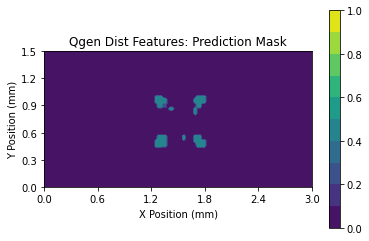

In [ ]:
#@title Plot Qgen Feature FULL MASK SET
# FOR PLOTTING: FLIP mesh_x and mesh_y if needed
if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

temp_plot_interval = .1
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

zone = 5

temp_max = np.amax(qgen_full_maskset)
#temp_max = np.amax(temp_data_dict['yinyang'][:])
upper_temp = 1 #math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = qgen_full_maskset[:,:,-17*6]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Qgen Dist Features: Prediction Mask')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()

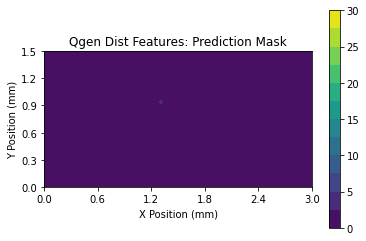

In [ ]:
#@title Plot Qgen Dist Feature FULL MASK SET
# FOR PLOTTING: FLIP mesh_x and mesh_y if needed
if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

temp_plot_interval = 5/2
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

zone = 5

temp_max = np.amax(qgen_dist_full_maskset)
#temp_max = np.amax(temp_data_dict['yinyang'][:])
upper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = qgen_dist_full_maskset[:,:,15]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Qgen Dist Features: Prediction Mask')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()

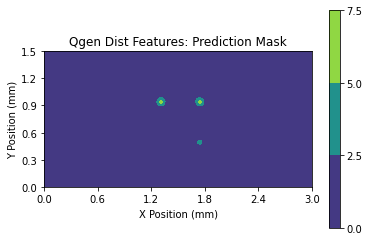

In [ ]:
#@title Plot Qgen Dist Feature
# FOR PLOTTING: FLIP mesh_x and mesh_y if needed
if mesh_y<mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

mask_mat = qgen_data_dict_compare[mask][:,:,0]
qgen_dist = get_qgen_dist(mask_mat, mesh_x=mesh_x, mesh_y=mesh_y, dist_exp = dist_exp)


if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

qgen_dist = qgen_dist**(1/1)

temp_plot_interval = 5/2
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

zone = 5

temp_max = np.amax(qgen_dist)
#temp_max = np.amax(temp_data_dict['yinyang'][:])
upper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = qgen_dist  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Qgen Dist Features: Prediction Mask')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()

In [ ]:
#qgen_dist_mat_train = np.repeat(qgen_dist_dict_compare[mask][:, :, np.newaxis], 135, axis=2)

In [ ]:
#@title Convert Mesh Form Data into Full Training Dataset
# Add density in later

if task == 'train':

    qgen_zone_list_dict = {}

    temp_list = []
    qgen_list = []

    mask_counter = 0
    for mask in train_img_list:
        #print(mask_counter)

        last_val_list[mask_counter] = 240

        # restrict the full dataset to a subset of the transient time window
        if last_val_list[mask_counter] > train_ts and time_subset == True:
            last_val_list[mask_counter] = train_ts

            temp_data_dict[mask] = temp_data_dict[mask][:,:,:train_ts]
            qgen_data_dict[mask] = qgen_data_dict[mask][:,:,:train_ts]
            dens_data_dict[mask] = dens_data_dict[mask][:,:,:train_ts]
            dens_change_data_dict[mask] = dens_change_data_dict[mask][:,:,:train_ts]

            print(time_diff_dict[mask].shape)
            time_diff_dict[mask] = time_diff_dict[mask][:train_ts-1]
            time_dict[mask] = time_dict[mask][:train_ts]
            print(time_diff_dict[mask].shape)


        # get temperature data
        if single_temp == True:
            temp_training_data = getAdjacentSingle(temp_data_dict[mask], last_val_list[mask_counter], mesh_x=60, mesh_y=118)
        else:
            temp_training_data, tme = getAdjacentFeatures(temp_data_dict[mask], last_val_list[mask_counter], num_adjacent = num_adjacent, udrl = udrl)    
        
        #temp_list.append(tme)
        #print(temp_training_data.shape)

        # get qgen data
        if single_qgen == True:
            qgen_training_data = getAdjacentSingle(qgen_data_dict[mask], last_val_list[mask_counter], mesh_x=60, mesh_y=118)
        else:
            qgen_training_data, temp_mat_exp = getAdjacentFeatures(qgen_data_dict[mask], last_val_list[mask_counter],num_adjacent = num_adjacent, udrl = udrl)
        
        # get dens data
        if single_dens == True:
            dens_training_data = getAdjacentSingle(dens_data_dict[mask], last_val_list[mask_counter], mesh_x=60, mesh_y=118)
        else:
            dens_training_data, temp_mat_exp = getAdjacentFeatures(dens_data_dict[mask], last_val_list[mask_counter],num_adjacent = num_adjacent, udrl = udrl)
        
        # get desnity change data
        if single_dens_change == True:
            dens_change_training_data = getAdjacentSingle(dens_change_data_dict[mask], last_val_list[mask_counter], mesh_x=60, mesh_y=118)
        else:
            dens_change_training_data, temp_mat_exp = getAdjacentFeatures(dens_change_data_dict[mask], last_val_list[mask_counter],num_adjacent = num_adjacent, udrl = udrl)




        # get qgen dist feature in mesh form
        qgen_dist_mat = np.repeat(qgen_dist_dict[mask][:, :, np.newaxis], temp_data_dict[mask].shape[2], axis=2)
        # get qgen dist data
        if single_qgen_dist == True:
            qgen_dist_training_data = getAdjacentSingle(qgen_dist_mat, last_val_list[mask_counter], mesh_x=60, mesh_y=118)
        else:
            qgen_dist_training_data, temp_mat_exp = getAdjacentFeatures(qgen_dist_mat, last_val_list[mask_counter],num_adjacent = num_adjacent, udrl = udrl)
        



        #qgen_list.append(temp_mat_exp)

        label_data = getTemperatureLabels(temp_data_dict[mask], last_val_list[mask_counter])
        
        # handle the time delta feature
        if incl_time == True:
            #print('Time Array Shape: ')
            #print(time_diff_dict[mask].shape)
            #print(time_diff_dict[mask].shape)
            #print(last_val_list[mask_counter])
            time_diff_data = get_time_feat(time_diff_dict[mask], mesh_x, mesh_y, last_val_list[mask_counter])
            time_data = get_time_feat(time_dict[mask][:-1], mesh_x, mesh_y, last_val_list[mask_counter])
            #mask_training_data = np.hstack((temp_training_data, qgen_training_data, qgen_dist_training_data, dens_training_data, dens_change_training_data, time_diff_data, label_data))
            mask_training_data = np.hstack((temp_training_data, qgen_training_data, qgen_dist_training_data, dens_training_data, time_diff_data, label_data)) # reserved for BIS (all BIS)
            #mask_training_data = np.hstack((temp_training_data, qgen_training_data, qgen_dist_training_data, dens_training_data, dens_change_training_data, time_diff_data, time_data ,label_data))
            #mask_training_data = np.hstack((temp_training_data, qgen_training_data, dens_training_data, dens_change_training_data, time_diff_data, time_data ,label_data))
            #mask_training_data = np.hstack((temp_training_data, qgen_training_data, dens_training_data, dens_change_training_data, time_diff_data, label_data))


        else:
            mask_training_data = np.hstack((temp_training_data, qgen_training_data, dens_training_data, dens_change_training_data, label_data))

        #print(mask_training_data.shape)

        # toggle for qgen_zones
        qgen_zone_list_dict[mask] = getQgenZones(qgen_data_dict[mask][:,:,-1], mesh_x=60, mesh_y=118, num_zones = num_zones, zone_depth = zone_depth, delay_jump = delay_jump, circle_zones = circle_zones, zone_exp = zone_exp)    
        if qgen_zones == True:
            mask_training_data = addQgenZones(mask_training_data, qgen_zone_list_dict[mask], mesh_x=60, mesh_y=118, num_zones = num_zones, zone_depth = zone_depth)

        if mask_counter !=0:
            mask_training_data = np.vstack((mask_training_data_prev, mask_training_data))

        mask_training_data_prev = mask_training_data
        mask_counter+=1

    training_data = mask_training_data

In [ ]:
#@title Convert Mesh Form Data into Initial Prediction Dataset (WATCH THIS ONE IF ERRORS)
# Add density in later

#pred_start = 80  # for testing only

temp_list2 = []

mask_counter = 0
for mask in pred_img_list:
    print(mask_counter)

    if last_val_list_compare[mask_counter] > train_ts and time_subset == True:
        last_val_list_compare[mask_counter] = train_ts

        temp_data_dict_compare[mask] = temp_data_dict_compare[mask][:,:,:train_ts]
        qgen_data_dict_compare[mask] = qgen_data_dict_compare[mask][:,:,:train_ts]
        dens_data_dict_compare[mask] = dens_data_dict_compare[mask][:,:,:train_ts]
        dens_change_data_dict_compare[mask] = dens_change_data_dict_compare[mask][:,:,:train_ts]

        time_diff_dict_compare[mask] = time_diff_dict_compare[mask][:train_ts-1]
        time_dict_compare[mask] = time_dict_compare[mask][:train_ts]

    # temperature data
    if single_temp == True:
        temp_prediction_data = getAdjacentSinglePredict(temp_data_dict_compare[mask][:,:,pred_start], last_val_list_compare[mask_counter], mesh_x=60, mesh_y=118)
    else:
        temp_prediction_data, tme = getAdjacentFeaturesPredict(temp_data_dict_compare[mask][:,:,pred_start], last_val_list_compare[mask_counter],num_adjacent = num_adjacent, udrl=udrl)    
    
    #temp_list2.append(tme)
    

    #
    #
    # qgen data
    if single_qgen == True:
        qgen_prediction_data = getAdjacentSinglePredict(qgen_full_maskset[:,:,pred_start], last_val_list_compare[mask_counter], mesh_x=60, mesh_y=118)
    else:
        qgen_prediction_data, temp_mat_exp = getAdjacentFeaturesPredict(qgen_full_maskset[:,:,pred_start], last_val_list_compare[mask_counter],num_adjacent = num_adjacent, udrl = udrl)    

    #
    #
    #

    # density data
    if single_dens == True:
        dens_prediction_data = getAdjacentSinglePredict(dens_data_dict_compare[mask][:,:,pred_start], last_val_list_compare[mask_counter], mesh_x=60, mesh_y=118)
    else:
        dens_prediction_data, temp_mat_exp = getAdjacentFeaturesPredict(dens_data_dict_compare[mask][:,:,pred_start], last_val_list_compare[mask_counter],num_adjacent = num_adjacent, udrl = udrl)    
    
    # density change data
    if single_dens_change == True:
        dens_change_prediction_data = getAdjacentSinglePredict(dens_change_data_dict_compare[mask][:,:,pred_start], last_val_list_compare[mask_counter], mesh_x=60, mesh_y=118)
    else:
        dens_change_prediction_data, temp_mat_exp = getAdjacentFeaturesPredict(dens_change_data_dict_compare[mask][:,:,pred_start], last_val_list_compare[mask_counter],num_adjacent = num_adjacent, udrl = udrl)    



    #
    #
    # get qgen dist feature in mesh form
    qgen_dist_mat_compare = np.repeat(qgen_dist_dict_compare[mask][:, :, np.newaxis], temp_data_dict_compare[mask].shape[2], axis=2)
    # get qgen dist data
    if single_qgen_dist == True:
        qgen_dist_prediction_data = getAdjacentSinglePredict(qgen_dist_full_maskset[:,:,pred_start], last_val_list_compare[mask_counter], mesh_x=60, mesh_y=118)
    else:
        qgen_dist_prediction_data, temp_mat_exp = getAdjacentFeaturesPredict(qgen_dist_full_maskset[:,:,pred_start], last_val_list_compare[mask_counter],num_adjacent = num_adjacent, udrl = udrl)
    
    #
    #
    #


    #temp_list2.append(temp_mat_exp) 

    # handle the time array    
    if incl_time == True:
        time_diff_array_pred = get_time_feat_predict(time_diff_dict_compare[mask][pred_start], mesh_x, mesh_y)
        time_array_pred = get_time_feat_predict(time_dict_compare[mask][pred_start], mesh_x, mesh_y)
        
        #mask_prediction_data = np.hstack((temp_prediction_data, qgen_prediction_data, qgen_dist_prediction_data, dens_prediction_data, dens_change_prediction_data, time_diff_array_pred))
        mask_prediction_data = np.hstack((temp_prediction_data, qgen_prediction_data, qgen_dist_prediction_data, dens_prediction_data, time_diff_array_pred)) # reserved for BIS
        #mask_prediction_data = np.hstack((temp_prediction_data, qgen_prediction_data, qgen_dist_prediction_data, dens_prediction_data, dens_change_prediction_data, time_diff_array_pred, time_array_pred))
        #mask_prediction_data = np.hstack((temp_prediction_data, qgen_prediction_data, dens_prediction_data, dens_change_prediction_data, time_diff_array_pred, time_array_pred))
        #mask_prediction_data = np.hstack((temp_prediction_data, qgen_prediction_data, dens_prediction_data, dens_change_prediction_data, time_diff_array_pred))

    else:
        mask_prediction_data = np.hstack((temp_prediction_data, qgen_prediction_data, dens_prediction_data, dens_change_prediction_data))


    #
    #
    # toggle for qgen_zone features
    qgen_zone_list_pred = getQgenZones(qgen_full_maskset[:,:,-1], mesh_x=60, mesh_y=118, num_zones = num_zones, zone_depth = zone_depth, delay_jump = delay_jump, circle_zones = circle_zones, zone_exp = zone_exp)      
    if qgen_zones == True:
        mask_prediction_data = addQgenZonesPredict(mask_prediction_data, qgen_zone_list_pred, mesh_x=60, mesh_y=118, num_zones = num_zones, zone_depth = zone_depth)
    
    #
    #
    #


    #qgen_data_dict_compare[mask][:,:,-1] # qgen_zone_list_pred
    if mask_counter !=0:
        mask_prediction_data = np.vstack((mask_prediction_data_prev, mask_prediction_data))


    mask_prediction_data_prev = mask_prediction_data
    mask_counter+=1

prediction_data = mask_prediction_data

0


In [ ]:
#@title Train Test Split    
if task == 'train':

    # variable and data setup
    x=training_data[:,:-1]
    y=training_data[:,-1]
    y=np.reshape(y, (-1,1)) # convert from (n, ) to (n, 1)

    # normalize data using sklearn
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    print(scaler_x.fit(x))
    xscale=scaler_x.transform(x)
    print(scaler_y.fit(y))
    yscale=scaler_y.transform(y)


    # split data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2)  # random_state=42


In [ ]:
#@title Train Neural Network
if task == 'train' and model_type == 'nn':
    
    input_dim = training_data.shape[1]-1
    model = Sequential()         #10        
    # add additional hidden layers


    # setup input layer
    if act_fun == 'leaky_relu':
        alpha = 0.3
        model.add(Dense(num_nodes, input_dim=input_dim, kernel_initializer='normal', activation=tf.keras.layers.LeakyReLU(alpha=alpha)))  # need to go back and add delta_t and delta_rho as the 16th and 17th feature vectors

    else:          
        model.add(Dense(num_nodes, input_dim=input_dim, kernel_initializer='normal', activation=act_fun))  # need to go back and add delta_t and delta_rho as the 16th and 17th feature vectors


    # setup hidden layers
    for layer in range(0, num_hidden_layers-1):

        if act_fun == 'leaky_relu':
            model.add(Dense(num_nodes, activation=tf.keras.layers.LeakyReLU(alpha=alpha)))
        else:    
            model.add(Dense(num_nodes, activation=act_fun)) # likely 'relu' for here and above
    
    # add single variable regression output layer
    model.add(Dense(1, activation='linear'))
    model.summary()

    # attempts to adjust model learning rate 
    #optimizer = keras.optimizers.Adam(lr=0.01)
    #optimizer = opt.adam.adam(learning_rate = .01)
    #model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae','accuracy'])


    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae','accuracy'])


    save_best_model = ModelCheckpoint(filepath, monitor='val_loss', 
                                      save_best_only=True, save_weights_only=True)


    history = model.fit(X_train, y_train, epochs=12, batch_size=50,  verbose=1, validation_split=0.2, callbacks=[save_best_model])
    model.load_weights(filepath)



In [ ]:
#@title Train XGBoost Model

'''
    X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2)  # random_state=42
    xgb_params = {
        "n_estimators": 400,
        "max_depth": 6,
        "min_samples_split": 2,
        "learning_rate": 0.02,
        "loss": "squared_error",
        "verbose": 2,
    }
    xgb_cv_params = {
        "n_estimators": [200,300,400,500],
        "max_depth": [3,4,5,6,7],
        "min_samples_split": [5],
        "learning_rate": [0.01],
        "loss": ["squared_error"],
    }
    xgb_regr = GradientBoostingRegressor(**xgb_params)
    xgb_regr.fit(X_train, y_train)
'''

'\n    X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2)  # random_state=42\n    xgb_params = {\n        "n_estimators": 400,\n        "max_depth": 6,\n        "min_samples_split": 2,\n        "learning_rate": 0.02,\n        "loss": "squared_error",\n        "verbose": 2,\n    }\n    xgb_cv_params = {\n        "n_estimators": [200,300,400,500],\n        "max_depth": [3,4,5,6,7],\n        "min_samples_split": [5],\n        "learning_rate": [0.01],\n        "loss": ["squared_error"],\n    }\n    xgb_regr = GradientBoostingRegressor(**xgb_params)\n    xgb_regr.fit(X_train, y_train)\n'

In [ ]:
#@title Train XGBoost (Python)

import xgboost as xgb

if task == 'train' and model_type == 'xgb':

    xgb_regr = xgb.XGBRegressor(**xgb_params)
    xgb_regr.fit(X_train, y_train)


In [ ]:
#@title Train LightGBM (Python)

import lightgbm as lgbm

if task == 'train' and model_type == 'lgbm':

    train_data = lgbm.Dataset(X_train, label=y_train.ravel())
    test_data = lgbm.Dataset(X_test, label=y_test.ravel())

    parameters = lgbm_params

    lgbm_regr = lgbm.train(parameters, 
                                train_data, 
                                valid_sets = test_data,
                          )
                                #num_boost_round = 800)


In [ ]:
#@title Select ML Model
import pickle

model_type = model_type
model_name = model_name
#model_name = '{0}_{1}_elem_{2}by{3}uniform_{4}mask_adj_4deep_expzones_single'.format(type_model, num_adjacent, num_zones, zone_depth, num_mask_train)

# BIS FOR ORIGINAL
#### model_name  = 'qgen_distance_added_BIS_1_21_alt' # BIS for error (10.45), % error <5%, (extrap) predicted "all" very well, but failed on "plus"
####model_name = 'qgen_distance_added_BIS_1_21' # tied BIS-a, 3x24 NN exp = 1.21,(extrap) predicted "plus" fairly well, but failed on "all"

# BIS FOR VAL
####model_name = 'qgen_distance_added_BIS_1_21_val_alt' # same settings as above, just different training and testing data

# BIS FOR GRAYSCALE
#model_name = 'qgen_distance_added_BIS_1_21_gray2s_16_nodes'

####model_name =  'qgen_distance_added' #'qgen_distance_added_singles' # BIS-b 3x24 NN exp = 1.2

####model_name = 'qgen_distance_added_single' #3BIS by 1 degree avg avg error 3x24 NN exp = 1.2
####model_name = 'qgen_distance_added_BIS2' # 2BIS, exp = 1.2

#if task == 'train':
#    model.save(filepath + model_name)

#joblib.dump(xgb_regr, filepath + model_name)
print(model_name)

if task == 'train':
    joblib.dump(scaler_x, filepath + model_name + '_scalar_x')
    joblib.dump(scaler_y, filepath + model_name + '_scalar_y')

if task == 'pred':
    scaler_x = joblib.load(filepath + model_name + '_scalar_x')
    scaler_y = joblib.load(filepath + model_name + '_scalar_y')



#type_model = "random_forest"
if model_type == "rf":
    #model = rfc_regr
    pass
elif model_type == "xgb":

    if task == 'train':
        model = xgb_regr
        pickle.dump(model, open(filepath + model_name, "wb"))
    
    if task == 'pred':
        model = pickle.load(open(filepath + model_name, "rb"))

elif model_type == "lgbm":

    if task == 'train':
        model = lgbm_regr
        pickle.dump(model, open(filepath + model_name, "wb"))

    if task == 'pred':
        model = pickle.load(open(filepath + model_name, "rb"))

elif model_type == "nn":

    if task == 'train':
        model.save(filepath + model_name)
    if task == 'pred':
        model = load_model(filepath + model_name)
else:
    assert False, "Choose model that has been trained properly"



qgen_distance_added_BIS_1_21_gray2s_16_nodes


In [ ]:
#@title Plot Loss
if task == 'train' and model_type == "nn":
    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
#@title Predict in Mesh Form
# ~40s

# list of masks to be run through at select timesteps when properties update
#mask_list

pred_name = pred_img_list[0]

if mesh_y<mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

num_time_pred = 131 #num_timesteps #133 #134         # 135
num_elem = mesh_x*mesh_y

# get initial condition of the predicting mask
#INITIAL TEMPERATURE
pred_array = prediction_data #[:num_elem,:-1] #prediction_data
predicted_temps = np.zeros((mesh_x, mesh_y,num_time_pred + 1))
predicted_temps[:,:,:pred_start] = temp_data_dict_compare[pred_name][:,:,:pred_start] # set the predicted temp array to be exactly the true value #temp_init
predicted_temps[:,:,pred_start] =  temp_data_dict_compare[pred_name][:,:,pred_start]  # start with a true value   #temp_mat_pred[:,:,0]    # temp_mat_pred

#INITIAL DENSITY
predicted_dens = np.zeros((mesh_x, mesh_y,num_time_pred + 1)) + dens_init
predicted_dens[:,:,:pred_start] = dens_data_dict_compare[pred_name][:,:,:pred_start] # set the predicted temp array to be exactly the true value #temp_init
predicted_dens[:,:,pred_start] =  dens_data_dict_compare[pred_name][:,:,pred_start]  # start with a true value   #temp_mat_pred[:,:,0]    # temp_mat_pred

#INITIAL DENSITY CHANGE
predicted_dens_change = np.zeros((mesh_x, mesh_y,num_time_pred + 1))
predicted_dens_change[:,:,:pred_start] = dens_change_data_dict_compare[pred_name][:,:,:pred_start] # set the predicted temp array to be exactly the true value #temp_init
predicted_dens_change[:,:,pred_start] =  dens_change_data_dict_compare[pred_name][:,:,pred_start]  # start with a true value   #temp_mat_pred[:,:,0]    # temp_mat_pred

# import georgina density curves
dens_curve_dict = import_dens_curves()

# run full prediction for all timesteps

print(pred_array.shape)

import time
start = time.time()


# ok out here when only one mask is used
'''
# QGEN FEATURE
if single_qgen == True:
    qgen_prediction_data = getAdjacentSinglePredict(qgen_data_dict_compare[mask][:,:,-1], last_val_list_compare[0], mesh_x=60, mesh_y=118)
else:
    qgen_prediction_data, nothing = getAdjacentFeaturesPredict(qgen_data_dict_compare[pred_name][:,:,-1], last_val_list_compare[0],num_adjacent = num_adjacent,  udrl = udrl)

# QGEN DIST FEATURE
# get qgen dist feature in mesh form
qgen_dist_mat_compare = np.repeat(qgen_dist_dict_compare[mask][:, :, np.newaxis], temp_data_dict_compare[mask].shape[2], axis=2)
# get qgen dist data
if single_qgen_dist == True:
    qgen_dist_prediction_data = getAdjacentSinglePredict(qgen_dist_mat_compare[:,:,-1], last_val_list_compare[0], mesh_x=60, mesh_y=118)
else:
    qgen_dist_prediction_data, temp_mat_exp = getAdjacentFeaturesPredict(qgen_dist_mat_compare[:,:,-1], last_val_list_compare[0],num_adjacent = num_adjacent, udrl = udrl)

qgen_zone_list_pred = getQgenZones(qgen_data_dict_compare[pred_name][:,:,-1], mesh_x, mesh_y, num_zones, zone_depth, delay_jump = delay_jump, circle_zones = circle_zones ,zone_exp = zone_exp)

'''

# create mesh sized sintering tracker

if pred_start == 0:
    sinter_hist = np.zeros((mesh_x, mesh_y))-1
else:
    sinter_hist = np.zeros((mesh_x, mesh_y))-1
    
#mask_index = 0

#print(prediction_data[:num_elem,:-1])
for ts in range(pred_start,num_time_pred): #num_time_pred-1): #num_time_pred):

    # get current time
    current_simulation_time = time_dict_compare[mask][ts] #[ts+1]
    #cst = current_simulation_time

    #print('loop')
    Xnew = pred_array
    Xnew = scaler_x.transform(Xnew)  # use predetermined scalar to scale new test data
    ynew = model.predict(Xnew).reshape(-1,1)
    temps = scaler_y.inverse_transform(ynew)   ### YOU MIGHT BE ABLE TO DIRECTLY SET THIS AS TEMP_PREDICTION_DATA

    # joblib parallelize ******
    counter = 0
    for col in range(0,mesh_y):
        for row in range(0,mesh_x):
            elem = col*mesh_x + row
            temp = temps[elem]
            predicted_temps[row,col,ts+1] = temp
            counter+=1

    #print(temp_data_dict_compare[mask].shape)
    ####qgen_prediction_data = getAdjacentSinglePredict(qgen_data_dict_compare[mask][:,:,-1], last_val_list_compare[0], mesh_x=60, mesh_y=118)

    if single_temp == True:    
        temp_prediction_data = getAdjacentSinglePredict(predicted_temps[:,:,ts+1], last_val_list_compare[0], mesh_x=60, mesh_y=118)
    else:    
        temp_prediction_data, nothing = getAdjacentFeaturesPredict(predicted_temps[:,:,ts+1], last_val_list_compare[0],num_adjacent = num_adjacent, udrl=udrl)
    #qgen_prediction_data, nothing = getAdjacentFeaturesPredict(qgen_data_dict_compare[pred_name][:,:,ts+1], last_val_list_compare[0],num_adjacent = num_adjacent)

    # handle the addition of the time array feature

    # dens_mat, temp_mat, sinter_thresh, sinter_hist, dens_curve_dict, sinter_time = .2
    # ADD IN DENSITY AS A FEATURE
    
    if int(current_simulation_time*10000)%int(sinter_time*10000)==0:  # check to see if timestep is a loadstep (density should update 9 times)                                
        predicted_dens[:,:,ts+1] = update_density(predicted_dens[:,:,ts], predicted_temps[:,:,ts+1], sinter_hist, dens_curve_dict, sinter_time = .2, sinter_thresh=450) # sinter time should be a function of total time and number of updates
    else:
        predicted_dens[:,:,ts+1] = predicted_dens[:,:,ts]
    

    #predicted_dens[:,:,ts+1] = dens_data_dict_compare[pred_name][:,:,ts+1]

    #print('Predicted Dens Shape')
    #print(predicted_dens[:,:,ts+1].shape)
    #print(ts+1)

    if single_dens == True:
        dens_prediction_data = getAdjacentSinglePredict(predicted_dens[:,:,ts+1], last_val_list_compare[0], mesh_x=60, mesh_y=118)
    else:
        dens_prediction_data, temp_mat_exp = getAdjacentFeaturesPredict(predicted_dens[:,:,ts+1], last_val_list_compare[0],num_adjacent = num_adjacent, udrl = udrl)    

    # ADD IN DENSITY CHANGE AS A FEATURE
    # calculate density change from last timestep
    predicted_dens_change[:,:,ts+1] = predicted_dens[:,:,ts+1] - predicted_dens[:,:,ts]

    
    # get desnity change data in training form
    if single_dens_change == True:
        dens_change_training_data = getAdjacentSinglePredict(predicted_dens_change[:,:,ts+1], last_val_list_compare[0], mesh_x=60, mesh_y=118)
    else:
        dens_change_training_data, temp_mat_exp = getAdjacentFeaturesPredict(predicted_dens_change[:,:,ts+1], last_val_list_compare[0],num_adjacent = num_adjacent, udrl = udrl)



    # handle time as a feature
    if incl_time == True:
        time_diff_array_pred = get_time_feat_predict(time_diff_dict_compare[mask][ts+1], mesh_x, mesh_y)
        time_array_pred = get_time_feat_predict(time_dict_compare[mask][ts+1], mesh_x, mesh_y)        
        #pred_array = np.hstack((temp_prediction_data, qgen_prediction_data, qgen_dist_prediction_data, dens_prediction_data, dens_change_prediction_data, time_diff_array_pred))
        pred_array = np.hstack((temp_prediction_data, qgen_prediction_data, qgen_dist_prediction_data, dens_prediction_data, time_diff_array_pred))  # reserved for BIS
        #pred_array = np.hstack((temp_prediction_data, qgen_prediction_data, qgen_dist_prediction_data, dens_prediction_data, dens_change_training_data, time_diff_array_pred, time_array_pred))
        #pred_array = np.hstack((temp_prediction_data, qgen_prediction_data, dens_prediction_data, dens_change_training_data, time_diff_array_pred, time_array_pred))
        #pred_array = np.hstack((temp_prediction_data, qgen_prediction_data, dens_prediction_data, dens_change_training_data, time_diff_array_pred))

    else:
        pred_array = np.hstack((temp_prediction_data, qgen_prediction_data, dens_prediction_data, dens_change_training_data))


    ####qgen_zone_list_pred = getQgenZones(qgen_data_dict_compare[pred_name][:,:,-1], mesh_x, mesh_y, num_zones, zone_depth)
    

    #
    #
    #
    
    if ts == pred_start or int(current_simulation_time*10000)%int(sinter_time*10000)==0:
        # QGEN FEATURE
        if single_qgen == True:
            qgen_prediction_data = getAdjacentSinglePredict(qgen_full_maskset[:,:,ts+1], last_val_list_compare[0], mesh_x=60, mesh_y=118)
        else:
            qgen_prediction_data, nothing = getAdjacentFeaturesPredict(qgen_full_maskset[:,:,ts+1], last_val_list_compare[0],num_adjacent = num_adjacent,  udrl = udrl)

        # QGEN DIST FEATURE
        # get qgen dist feature in mesh form
        qgen_dist_mat_compare = np.repeat(qgen_dist_dict_compare[mask][:, :, np.newaxis], temp_data_dict_compare[mask].shape[2], axis=2)
        # get qgen dist data
        if single_qgen_dist == True:
            qgen_dist_prediction_data = getAdjacentSinglePredict(qgen_dist_full_maskset[:,:,ts+1], last_val_list_compare[0], mesh_x=60, mesh_y=118)
        else:
            qgen_dist_prediction_data, temp_mat_exp = getAdjacentFeaturesPredict(qgen_dist_full_maskset[:,:,ts+1], last_val_list_compare[0],num_adjacent = num_adjacent, udrl = udrl)

        
        qgen_zone_list_pred = getQgenZones(qgen_full_maskset[:,:,ts+1], mesh_x, mesh_y, num_zones, zone_depth, delay_jump = delay_jump, circle_zones = circle_zones ,zone_exp = zone_exp)


    #
    #
    #


    # qgen_zone toggle
    if qgen_zones == True:
        pred_array = addQgenZonesPredict(pred_array, qgen_zone_list_pred, mesh_x, mesh_y, num_zones, zone_depth) # qgen_zone_list_pred
    #print(pred_array.shape)


end = time.time()
print("Time: ", end - start)

(7080, 35)
Time:  26.882333755493164


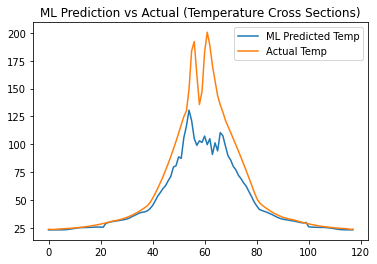

In [ ]:
#@title Plot Predicted vs Actual Temp Cross Section at Specified Timestep
cs_ts = 131 #num_timesteps
mask_name = pred_name
y = predicted_temps[30,:,cs_ts]
y = np.reshape(y, (-1,1))
x = np.array([range(0, len(y)-1 + 1)]).transpose()

y2 = temp_data_dict_compare[mask_name][30,:,cs_ts] 
y2 = np.reshape(y2, (-1,1))

plt.plot(x, y, label = "ML Predicted Temp")
plt.plot(x, y2, label = "Actual Temp")
plt.legend()
plt.title('ML Prediction vs Actual (Temperature Cross Sections)')
plt.show()

(132, 1)
(132, 1)


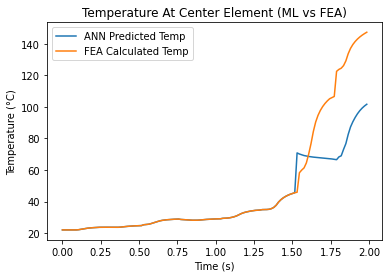

In [ ]:

#@title Plot Predicted vs Actual Temp of Individual Elements
row = 30
col = 59
y = predicted_temps[row,col ,:]
y = np.reshape(y, (-1,1))
#x = np.array([range(0, num_time_pred+1)]).transpose()          xgb_res
x = np.arange(0, 2, 2/(num_time_pred + 1)).transpose()
x = np.reshape(x, (-1,1))

print(x.shape)
print(y.shape)

y2 = temp_data_dict_compare[mask_name][row,col ,:-1]
y2 = np.reshape(y2, (-1,1))

plt.plot(x, y, label = "ANN Predicted Temp")
plt.plot(x, y2, label = "FEA Calculated Temp")
plt.legend()
plt.title('Temperature At Center Element (ML vs FEA)')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.show()

In [ ]:
#@title Plot NN Predicted Temp
# create temperature plot
import math

'''

# FOR PLOTTING: FLIP mesh_x and mesh_y
if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

temp_plot_interval = 100/2
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

#temp_max = np.amax(temp_data_dict_compare[mask_name][:]) + 100 #+ 1*temp_plot_interval
temp_max = 1200 #np.amax(predicted_temps[:])
upper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = predicted_temps[:,:,133]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('NN Predicted Temperatures at t=.015s (°C)')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()


'''

"\n\n# FOR PLOTTING: FLIP mesh_x and mesh_y\nif mesh_y>mesh_x:\n    mesh_x, mesh_y = mesh_y, mesh_x\n\ntemp_plot_interval = 100/2\nx_plot_interval = 5\ny_plot_interval = 5\ny_max = 1.5\nx_max = 3\n\n#temp_max = np.amax(temp_data_dict_compare[mask_name][:]) + 100 #+ 1*temp_plot_interval\ntemp_max = 1200 #np.amax(predicted_temps[:])\nupper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval\n\nxlist = np.linspace(0, mesh_x, mesh_x)\nylist = np.linspace(0,mesh_y, mesh_y)\nX, Y = np.meshgrid(xlist, ylist)\nZ = predicted_temps[:,:,133]  #np.sqrt(X**2 + Y**2)\nZ = np.flip(Z,axis=0)\nfig,ax=plt.subplots(1,1)\ncp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))\nfig.colorbar(cp) # Add a colorbar to a plot\nax.set_title('NN Predicted Temperatures at t=.015s (°C)')\nax.set_aspect('equal')\n\nax.set_xlabel('X Position (mm)')\nax.set_ylabel('Y Position (mm)')\n\nx_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_in

In [ ]:
#@title Plot FEA Predicted Temp
# create temperature plot
# FOR PLOTTING: FLIP mesh_x and mesh_y

'''

if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x


temp_plot_interval = 100/5*(5/3)
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

temp_max = np.amax(temp_data_dict_compare[mask_name][:]) #+ 100
#temp_max = np.amax(temp_data_dict['yinyang'][:])
upper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = temp_data_dict_compare[mask_name][:,:,133]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('FEA Temperatures (°C)')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()

'''

"\n\nif mesh_y>mesh_x:\n    mesh_x, mesh_y = mesh_y, mesh_x\n\n\ntemp_plot_interval = 100/5*(5/3)\nx_plot_interval = 5\ny_plot_interval = 5\ny_max = 1.5\nx_max = 3\n\ntemp_max = np.amax(temp_data_dict_compare[mask_name][:]) #+ 100\n#temp_max = np.amax(temp_data_dict['yinyang'][:])\nupper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval\n\nxlist = np.linspace(0, mesh_x, mesh_x)\nylist = np.linspace(0,mesh_y, mesh_y)\nX, Y = np.meshgrid(xlist, ylist)\nZ = temp_data_dict_compare[mask_name][:,:,133]  #np.sqrt(X**2 + Y**2)\nZ = np.flip(Z,axis=0)\n#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)\n\nfig,ax=plt.subplots(1,1)\ncp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))\nfig.colorbar(cp) # Add a colorbar to a plot\nax.set_title('FEA Temperatures (°C)')\nax.set_aspect('equal')\n\nax.set_xlabel('X Position (mm)')\nax.set_ylabel('Y Position (mm)')\n\nx_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mes

In [ ]:
#@title Plot Heat Generation
# create temperature plot

'''

if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = qgen_data_dict_compare[mask_name][:,:,133]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
#Z = qgen_data_dict['smallsquare'][:,:,133]
fig,ax=plt.subplots(1,1)


#c_white = mpl.colors.colorConverter.to_rgba('white',alpha = 0)
#c_black= mpl.colors.colorConverter.to_rgba('black',alpha = 1)
#cmap = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_black])


cp = ax.contourf(X, Y, Z, levels=[0,0.5,1], cmap = mpl.colors.ListedColormap(['black', 'white']), interpolation='nearest')    #cmap = 'Greys_r', binary_r
#fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Normalized Qgen (Current Mask)')
ax.set_aspect('equal')

ax.set_xlabel('X Distance (mm)')
ax.set_ylabel('Y Distance (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

plt.show()

'''


"\n\nif mesh_y>mesh_x:\n    mesh_x, mesh_y = mesh_y, mesh_x\n\nxlist = np.linspace(0, mesh_x, mesh_x)\nylist = np.linspace(0,mesh_y, mesh_y)\nX, Y = np.meshgrid(xlist, ylist)\nZ = qgen_data_dict_compare[mask_name][:,:,133]  #np.sqrt(X**2 + Y**2)\nZ = np.flip(Z,axis=0)\n#Z = qgen_data_dict['smallsquare'][:,:,133]\nfig,ax=plt.subplots(1,1)\n\n\n#c_white = mpl.colors.colorConverter.to_rgba('white',alpha = 0)\n#c_black= mpl.colors.colorConverter.to_rgba('black',alpha = 1)\n#cmap = mpl.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_white,c_black])\n\n\ncp = ax.contourf(X, Y, Z, levels=[0,0.5,1], cmap = mpl.colors.ListedColormap(['black', 'white']), interpolation='nearest')    #cmap = 'Greys_r', binary_r\n#fig.colorbar(cp) # Add a colorbar to a plot\nax.set_title('Normalized Qgen (Current Mask)')\nax.set_aspect('equal')\n\nax.set_xlabel('X Distance (mm)')\nax.set_ylabel('Y Distance (mm)')\n\nx_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)\nax.set_xtic

In [ ]:
#@title Plot Qgen Zone Feature
# create density plot

'''

if mesh_y<mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

xlist = np.linspace(0, mesh_y, mesh_y)
ylist = np.linspace(0,mesh_x, mesh_x)
X, Y = np.meshgrid(xlist, ylist)
#Z = qgen_mat_train[:,:,133]  #np.sqrt(X**2 + Y**2)
Z = qgen_zone_list_dict['ibeam'][-2]  #np.sqrt(X**2 + Y**2)
#Z = qgen_zone_list[2]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Qgen Zone Features for Ibeam')
ax.set_aspect('equal')

plt.show()

'''

"\n\nif mesh_y<mesh_x:\n    mesh_x, mesh_y = mesh_y, mesh_x\n\nxlist = np.linspace(0, mesh_y, mesh_y)\nylist = np.linspace(0,mesh_x, mesh_x)\nX, Y = np.meshgrid(xlist, ylist)\n#Z = qgen_mat_train[:,:,133]  #np.sqrt(X**2 + Y**2)\nZ = qgen_zone_list_dict['ibeam'][-2]  #np.sqrt(X**2 + Y**2)\n#Z = qgen_zone_list[2]\nfig,ax=plt.subplots(1,1)\ncp = ax.contourf(X, Y, Z)\nfig.colorbar(cp) # Add a colorbar to a plot\nax.set_title('Qgen Zone Features for Ibeam')\nax.set_aspect('equal')\n\nplt.show()\n\n"

In [ ]:
#@title Plot Qgen Zone Feature for Prediction
# create temperature plot
# FOR PLOTTING: FLIP mesh_x and mesh_y


'''

if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x


temp_plot_interval = 12.5*2
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

zone = 5

temp_max = np.amax(qgen_zone_list_pred[zone - 1])
#temp_max = np.amax(temp_data_dict['yinyang'][:])
upper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = qgen_zone_list_pred[zone - 1]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Qgen Zone Features: Prediction Mask')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()

'''

"\n\nif mesh_y>mesh_x:\n    mesh_x, mesh_y = mesh_y, mesh_x\n\n\ntemp_plot_interval = 12.5*2\nx_plot_interval = 5\ny_plot_interval = 5\ny_max = 1.5\nx_max = 3\n\nzone = 5\n\ntemp_max = np.amax(qgen_zone_list_pred[zone - 1])\n#temp_max = np.amax(temp_data_dict['yinyang'][:])\nupper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval\n\nxlist = np.linspace(0, mesh_x, mesh_x)\nylist = np.linspace(0,mesh_y, mesh_y)\nX, Y = np.meshgrid(xlist, ylist)\nZ = qgen_zone_list_pred[zone - 1]  #np.sqrt(X**2 + Y**2)\nZ = np.flip(Z,axis=0)\n#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)\n\nfig,ax=plt.subplots(1,1)\ncp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))\nfig.colorbar(cp) # Add a colorbar to a plot\nax.set_title('Qgen Zone Features: Prediction Mask')\nax.set_aspect('equal')\n\nax.set_xlabel('X Position (mm)')\nax.set_ylabel('Y Position (mm)')\n\nx_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_

In [ ]:
#@title #TEMPORARY NUM_TIMESTEP CHANGE
print(num_timesteps)

131


In [ ]:
print(np.amax(predicted_temps[:,:,14]))

59.70611


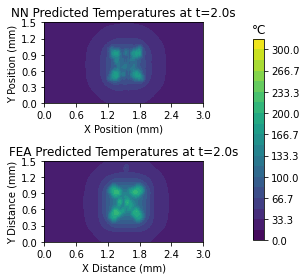

In [ ]:
#@title Temperature Map Comparison Plot
# create temperature plot
import math

# FOR PLOTTING: FLIP mesh_x and mesh_y
if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x


max_time_s = 2
max_timestep = num_timesteps #133
timestep = num_timesteps #133
time_s = round(timestep*max_time_s/max_timestep,3)

temp_plot_interval = 100/6
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

temp_max = np.amax(temp_data_dict_compare[mask_name][:]) +100 #+4*temp_plot_interval
upper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = predicted_temps[:,:,timestep]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
fig,[ax,ax2]=plt.subplots(2,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
#fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('NN Predicted Temperatures at t=' + str(time_s) + 's')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))



Z2 = temp_data_dict_compare[mask_name][:,:,timestep]  #np.sqrt(X**2 + Y**2)
Z2 = np.flip(Z2,axis=0)
cp2 = ax2.contourf(X, Y, Z2, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
#fig.colorbar(cp2) # Add a colorbar to a plot
ax2.set_title('FEA Predicted Temperatures at t=' + str(time_s) + 's')
ax2.set_aspect('equal')

ax2.set_xlabel('X Distance (mm)')
ax2.set_ylabel('Y Distance (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax2.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax2.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax2.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax2.set_yticklabels(y_values.round(2))


#plot color bar
fig.subplots_adjust(right=1.05)
cbar_ax = fig.add_axes([0.80, 0.15, 0.025, 0.7])
cbr = fig.colorbar(cp2, cax=cbar_ax)  # label = '°C' ... would want this above colorbar
cbr.ax.set_title('°C')
plt.tight_layout()
plt.show()

2800


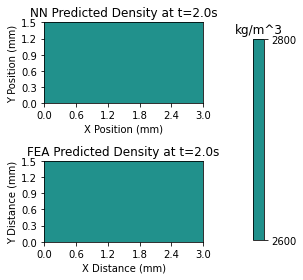

In [ ]:
#@title Density Map Comparison Plot
# create temperature plot
import math

# FOR PLOTTING: FLIP mesh_x and mesh_y
if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

max_time_s = 2
max_timestep = num_timesteps #133
timestep = num_timesteps #133
time_s = round(timestep*max_time_s/max_timestep,3)

dens_plot_interval = 100*2
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

lower_dens = 2600
dens_max = np.amax(predicted_dens[:,:,timestep]) + 100 #+4*dens_plot_interval
upper_dens = math.ceil(dens_max/dens_plot_interval)*dens_plot_interval
print(upper_dens)

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
Z = predicted_dens[:,:,timestep]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
fig,[ax,ax2]=plt.subplots(2,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(lower_dens,upper_dens+dens_plot_interval,dens_plot_interval)))
#fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('NN Predicted Density at t=' + str(time_s) + 's')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))



Z2 = dens_data_dict_compare[mask_name][:,:,timestep]  #np.sqrt(X**2 + Y**2)
Z2 = np.flip(Z2,axis=0)
cp2 = ax2.contourf(X, Y, Z2, levels=list(np.arange(lower_dens,upper_dens+dens_plot_interval,dens_plot_interval)))
#fig.colorbar(cp2) # Add a colorbar to a plot
ax2.set_title('FEA Predicted Density at t=' + str(time_s) + 's')
ax2.set_aspect('equal')

ax2.set_xlabel('X Distance (mm)')
ax2.set_ylabel('Y Distance (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax2.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax2.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax2.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax2.set_yticklabels(y_values.round(2))


#plot color bar
fig.subplots_adjust(right=1.05)
cbar_ax = fig.add_axes([0.80, 0.15, 0.025, 0.7])
cbr = fig.colorbar(cp2, cax=cbar_ax)  # label = '°C' ... would want this above colorbar
cbr.ax.set_title('kg/m^3')
plt.tight_layout()
plt.show()

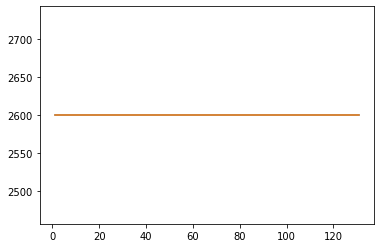

In [ ]:
#@title Density Comparison
x = np.arange(1,predicted_dens.shape[2])
y = np.array([np.amax(predicted_dens[:,:,num]) for num in x]) #dens_data_dict_compare[mask_name]
y2 = np.array([np.amax(dens_data_dict_compare[mask_name][:,:,num]) for num in x])
plt.plot(x, y)
plt.plot(x, y2)

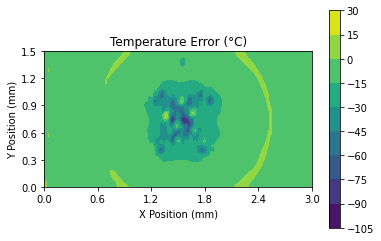

In [ ]:
#@title Temperature Error Plot

# create temperature plot
import math

# FOR PLOTTING: FLIP mesh_x and mesh_y
if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

ts = num_timesteps #133

temp_plot_interval = 10
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

error_mat = predicted_temps - temp_data_dict_compare[mask_name][:,:,:-1]
Z = error_mat[:,:,ts]

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
#Z = predicted_temps[:,:,133]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Temperature Error (°C)')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()

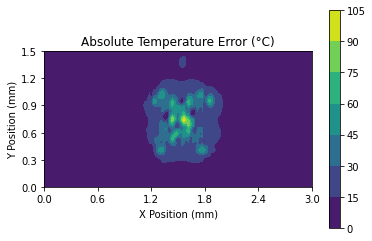

In [ ]:
#@title Absolute Temperature Error Plot

# create temperature plot
import math

# FOR PLOTTING: FLIP mesh_x and mesh_y
if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

ts = num_timesteps #125 #133

temp_plot_interval = 10/2
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

error_mat_abs = abs(temp_data_dict_compare[mask_name][:,:,:-1] - predicted_temps)
Z = error_mat_abs[:,:,ts]

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
#Z = predicted_temps[:,:,133]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Absolute Temperature Error (°C)')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()

In [ ]:
ts = ts
print("Mean Absolute Error: " + str(np.average(error_mat_abs[:,:,ts])))
print("Max Absolute Error: " + str(np.amax(error_mat_abs[:,:,ts])))
print("Min Absolute Error: " + str(np.amin(error_mat_abs[:,:,ts])))

max_temp = np.amax(temp_data_dict_compare[mask_name][:,:,ts])
error_mat_perc = error_mat_abs[:,:,ts]/temp_data_dict_compare[mask_name][:,:,ts]*100
print("Max Temp: " + str(max_temp))
print("Average Temperature: " + str(np.average(temp_data_dict_compare[mask_name][:,:,ts])))
print("Average Percent Error: " + str(np.average(error_mat_perc[:,:])))
print("Max Percent Error: " + str(np.amax(error_mat_perc[:])))
print(ts) # circle5

Mean Absolute Error: 6.460407022260591
Max Absolute Error: 101.03482807373047
Min Absolute Error: 0.00024117675781099024
Max Temp: 212.19689
Average Temperature: 46.33023333403955
Average Percent Error: 8.854078719718828
Max Percent Error: 50.343762039867066
131


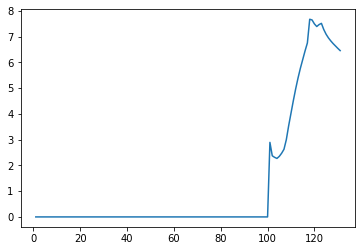

In [ ]:
#@title Average Temperature Error vs Number of Predictions 
x = np.arange(1,predicted_dens.shape[2])
y = np.array([np.amax(np.average(error_mat_abs[:,:,num])) for num in x]) #dens_data_dict_compare[mask_name]
plt.plot(x, y)

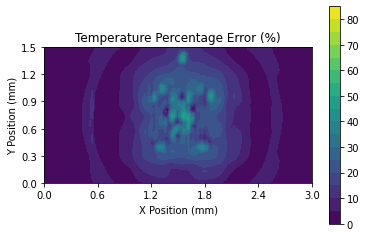

In [ ]:
#@title Temperature Percentage Error Plot

# create temperature plot
import math

# FOR PLOTTING: FLIP mesh_x and mesh_y
if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x

temp_plot_interval = 10/2
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

Z = error_mat_perc

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
#Z = predicted_temps[:,:,133]  #np.sqrt(X**2 + Y**2)
Z = np.flip(Z,axis=0)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,80+10,temp_plot_interval)))
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Temperature Percentage Error (%)')
ax.set_aspect('equal')

ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')

x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
ax.set_xticks(x_tick_locs)
x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
ax.set_xticklabels(x_values.round(2))

y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
ax.set_yticks(y_tick_locs)
y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
ax.set_yticklabels(y_values.round(2))

#fig.clim(0, 1000)
plt.show()

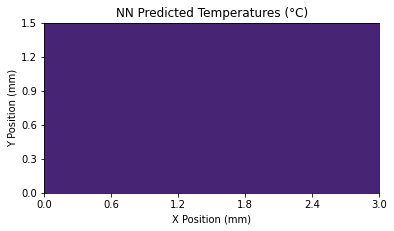

In [ ]:
#@title Plot Predicted Temp (Video)

# FOR PLOTTING: FLIP mesh_x and mesh_y



import matplotlib.animation as animation

if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x


temp_plot_interval = 100/2
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

temp_max = np.amax(predicted_temps[:]) + 50
#temp_max = np.amax(temp_data_dict['yinyang'][:])
upper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
#Z = temp_data_dict_compare[mask_name][:,:,133]  #np.sqrt(X**2 + Y**2)
#Z = np.flip(Z,axis=0)
#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)

fig,ax=plt.subplots(1,1)

cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
#fig.colorbar(cp) # Add a colorbar to a plot

def animate(i):
        
    #Z = temp_data_dict_compare[mask_name][:,:,i]  #np.sqrt(X**2 + Y**2)
    Z = predicted_temps[:,:,i]
    Z = np.flip(Z,axis=0)

    ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))

    
    ax.set_title('NN Predicted Temperatures (°C)')
    ax.set_aspect('equal')

    ax.set_xlabel('X Position (mm)')
    ax.set_ylabel('Y Position (mm)')

    x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
    ax.set_xticks(x_tick_locs)
    x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
    ax.set_xticklabels(x_values.round(2))

    y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
    ax.set_yticks(y_tick_locs)
    y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
    ax.set_yticklabels(y_values.round(2))
    

# Call animate method
ani = animation.FuncAnimation(fig, animate, num_timesteps, interval=50, blit=False)

from matplotlib import rc
rc('animation', html='jshtml')

ani

# Display the plot
#plt.show()


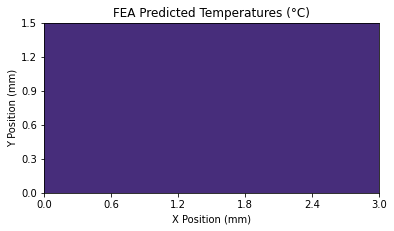

In [ ]:
#@title Plot Predicted Temp (Video)

# FOR PLOTTING: FLIP mesh_x and mesh_y



import matplotlib.animation as animation

if mesh_y>mesh_x:
    mesh_x, mesh_y = mesh_y, mesh_x


temp_plot_interval = 100
x_plot_interval = 5
y_plot_interval = 5
y_max = 1.5
x_max = 3

temp_max = np.amax(temp_data_dict_compare[mask_name][:]) + 100
#temp_max = np.amax(temp_data_dict['yinyang'][:])
upper_temp = math.ceil(temp_max/temp_plot_interval)*temp_plot_interval

xlist = np.linspace(0, mesh_x, mesh_x)
ylist = np.linspace(0,mesh_y, mesh_y)
X, Y = np.meshgrid(xlist, ylist)
#Z = temp_data_dict_compare[mask_name][:,:,133]  #np.sqrt(X**2 + Y**2)
#Z = np.flip(Z,axis=0)
#Z = temp_data_dict['yinyang'][:,:,133]  #np.sqrt(X**2 + Y**2)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))
#fig.colorbar(cp) # Add a colorbar to a plot

def animate(i):
        
    Z = temp_data_dict_compare[mask_name][:,:,i]  #np.sqrt(X**2 + Y**2)
    #Z = predicted_temps[:,:,i]
    Z = np.flip(Z,axis=0)

    ax.contourf(X, Y, Z, levels=list(np.arange(0,upper_temp+temp_plot_interval,temp_plot_interval)))

    
    ax.set_title('FEA Predicted Temperatures (°C)')
    ax.set_aspect('equal')

    ax.set_xlabel('X Position (mm)')
    ax.set_ylabel('Y Position (mm)')

    x_tick_locs = np.arange(0, mesh_x+mesh_x/x_plot_interval, mesh_x/x_plot_interval)
    ax.set_xticks(x_tick_locs)
    x_values = np.arange(0, x_max+x_max/x_plot_interval, x_max/x_plot_interval)
    ax.set_xticklabels(x_values.round(2))

    y_tick_locs = np.arange(0, mesh_y + mesh_y/y_plot_interval, mesh_y/y_plot_interval)
    ax.set_yticks(y_tick_locs)
    y_values = np.arange(0, y_max + y_max/y_plot_interval, y_max/y_plot_interval)
    ax.set_yticklabels(y_values.round(2))
    

# Call animate method
ani = animation.FuncAnimation(fig, animate, num_timesteps, interval=50, blit=False)

from matplotlib import rc
rc('animation', html='jshtml')

ani
